In [25]:
import pandas as pd
file_path=r"C:\Users\vaish_4d7erm7\Downloads\sensor_data.csv"
df= pd.read_csv(file_path)

In [26]:
df

,timestamp,temperature,humidity
0,795666791,18,10
1,795666801,18,10
2,795666811,18,10
3,795666821,18,10
4,795666831,18,10
...,...,...,...
14698,795811726,20,34
14699,795811736,20,34
14700,795811746,20,34
14701,795811756,20,34


In [31]:
corrected_timestamp = df["timestamp"] - (795666791 - 1710801452)  # Adjust based on actual reference
df["datetime"] = pd.to_datetime(corrected_timestamp, unit="s", utc=True)
df["datetime"] = df["datetime"].apply(lambda x: x.replace(year=2025) if x.year == 2024 else x)
print(df)

       timestamp  temperature  humidity                  datetime
0      795666791           18        10 2025-03-18 22:37:32+00:00
1      795666801           18        10 2025-03-18 22:37:42+00:00
2      795666811           18        10 2025-03-18 22:37:52+00:00
3      795666821           18        10 2025-03-18 22:38:02+00:00
4      795666831           18        10 2025-03-18 22:38:12+00:00
...          ...          ...       ...                       ...
14698  795811726           20        34 2025-03-20 14:53:07+00:00
14699  795811736           20        34 2025-03-20 14:53:17+00:00
14700  795811746           20        34 2025-03-20 14:53:27+00:00
14701  795811756           20        34 2025-03-20 14:53:37+00:00
14702  795811766           20        34 2025-03-20 14:53:47+00:00

[14703 rows x 4 columns]


In [32]:
df_cleaned = df.drop_duplicates(subset=["temperature", "humidity"], keep="first")
print(df_cleaned)

       timestamp  temperature  humidity                  datetime
0      795666791           18        10 2025-03-18 22:37:32+00:00
22     795667009           17        10 2025-03-18 22:41:10+00:00
99     795667770           19        10 2025-03-18 22:53:51+00:00
206    795668826           20        10 2025-03-18 23:11:27+00:00
571    795672429           21        10 2025-03-19 00:11:30+00:00
...          ...          ...       ...                       ...
14340  795808191           20        27 2025-03-20 13:54:12+00:00
14474  795809510           20        31 2025-03-20 14:16:11+00:00
14524  795810003           20        32 2025-03-20 14:24:24+00:00
14541  795810170           20        33 2025-03-20 14:27:11+00:00
14594  795810692           20        34 2025-03-20 14:35:53+00:00

[106 rows x 4 columns]


In [33]:
df.describe()

,timestamp,temperature,humidity
count,1.470300e+04,14703.000000,14703.000000
mean,7.957393e+08,21.103108,19.913351
std,4.186785e+04,3.689851,10.241804
min,7.956668e+08,15.000000,10.000000
25%,7.957030e+08,18.000000,10.000000
50%,7.957392e+08,21.000000,10.000000
75%,7.957756e+08,23.000000,30.000000
max,7.958118e+08,30.000000,42.000000


In [12]:
!pip install matplotlib
!pip install scikit-learn

   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.1 MB 4.2 MB/s eta 0:00:03
   ---- ----------------------------------- 1.3/11.1 MB 3.5 MB/s eta 0:00:03
   ------- -------------------------------- 2.1/11.1 MB 3.7 MB/s eta 0:00:03
   --------- ------------------------------ 2.6/11.1 MB 3.3 MB/s eta 0:00:03
   ----------- ---------------------------- 3.1/11.1 MB 3.1 MB/s eta 0:00:03
   ------------- -------------------------- 3.7/11.1 MB 3.1 MB/s eta 0:00:03
   --------------- ------------------------ 4.2/11.1 MB 3.0 MB/s eta 0:00:03
   ----------------- ---------------------- 5.0/11.1 MB 3.0 MB/s eta 0:00:03
   -------------------- ------------------- 5.8/11.1 MB 3.1 MB/s eta 0:00:02
   ----------------------- ---------------- 6.6/11.1 MB 3.2 MB/s eta 0:00:02
   ------------------------- -------------- 7.1/11.1 MB 3.2 MB/s eta 0:00:02
   ----------------------------- ---------- 8.1/11.1 MB 3.3 MB/s eta 0:00:01
   ---

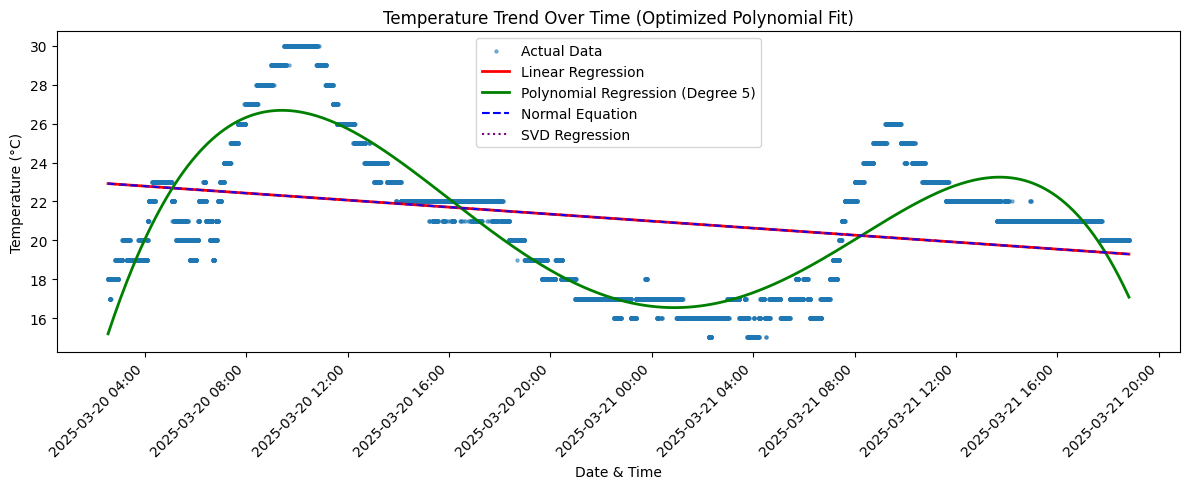

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

# Ensure timestamps are correctly converted
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")  # Use "ms" if necessary
df["timestamp"] = df["timestamp"] + pd.DateOffset(years=30)  # Adjust incorrect years

# Standardize time for ML models
scaler = StandardScaler()
X = scaler.fit_transform(df["timestamp"].astype("int64").values.reshape(-1, 1) // 10**9)  # Convert to seconds
y = df["temperature"].values

# Fit Linear Regression
linear_model = LinearRegression()
linear_model.fit(X, y)
y_linear_pred = linear_model.predict(X)

# Fit Polynomial Regression
poly_degree = 5
poly_model = make_pipeline(PolynomialFeatures(degree=poly_degree), LinearRegression())
poly_model.fit(X, y)

# Generate smooth polynomial predictions
X_smooth = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
y_poly_pred = poly_model.predict(X_smooth)

# Compute Least Squares Solution using Normal Equation
X_b = np.c_[np.ones((X.shape[0], 1)), X]
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
y_normal_eq_pred = X_b @ theta_best

# Singular Value Decomposition (SVD) for Matrix Factorization
U, S, Vt = np.linalg.svd(X_b, full_matrices=False)
S_inv = np.diag(1 / S)
theta_svd = Vt.T @ S_inv @ U.T @ y
y_svd_pred = X_b @ theta_svd

# Convert scaled X values back to timestamps
X_smooth_dates = pd.to_datetime(scaler.inverse_transform(X_smooth).flatten().astype("int64"), unit="s")

# Plot results
plt.figure(figsize=(12, 5))
plt.scatter(df["timestamp"], df["temperature"], label="Actual Data", s=5, alpha=0.5)
plt.plot(df["timestamp"], y_linear_pred, label="Linear Regression", color="red", linewidth=2)
plt.plot(X_smooth_dates, y_poly_pred, label=f"Polynomial Regression (Degree {poly_degree})", color="green", linewidth=2)
plt.plot(df["timestamp"], y_normal_eq_pred, label="Normal Equation", color="blue", linestyle="dashed")
plt.plot(df["timestamp"], y_svd_pred, label="SVD Regression", color="purple", linestyle="dotted")

# Format x-axis
plt.xlabel("Date & Time")
plt.ylabel("Temperature (°C)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45, ha="right")

plt.legend()
plt.title("Temperature Trend Over Time (Optimized Polynomial Fit)")
plt.tight_layout()
plt.show()



In [71]:
# Newton's Method for finding optimal heating/cooling thresholds
def newtons_method(temps, initial_threshold=22, tol=1e-6, max_iter=100):
    threshold = initial_threshold
    for _ in range(max_iter):
        gradient = sum(2 * (temp - threshold) for temp in temps)
        hessian = 2 * len(temps)
        step = gradient / hessian
        if abs(step) < tol:
            break
        threshold -= step
    return threshold

# Calculate optimal threshold using Newton's Method
temp_series = df["temperature"].values
optimal_temp = newtons_method(temp_series)
print(f"Optimal heating/cooling threshold (Newton's Method): {optimal_temp}")

# Iterative function to find the best heating/cooling threshold
def optimal_threshold(temps, heating_threshold=20, cooling_threshold=25):
    cost = 0
    for temp in temps:
        if temp < heating_threshold:
            cost += (heating_threshold - temp) ** 2
        elif temp > cooling_threshold:
            cost += (temp - cooling_threshold) ** 2
    return cost

# Calculate cost for given thresholds
total_cost = optimal_threshold(temp_series)
print(f"Total deviation cost: {total_cost}")


Optimal heating/cooling threshold (Newton's Method): 1.1369454169365081e+30
Total deviation cost: 68357
